<h1>Processed Heart Failure Data from Cleveland</h1>

<u><h2>Introduction:</h2></u>

<t>There are many indicators of the likelihood of heart disease in patients, often discernible through various traits. Heart failure typically occurs when the heart does not pump blood at a sufficient rate. It can cause fluid buildup in the lungs, resulting in symptoms such as shortness of breath, fatigue/weakness, nausea, coughing/wheezing, rapid weight gain, and chest pain. The Heart Failure dataset is collected from hospitals in Cleveland, Ohio. It analyzes many variables that could suggest the presence of heart disease, such as age and maximum heart rate achieved (bpm). The premise of our project revolves around a hypothetical situation in which we are required to determine the extent to which someone may be experiencing heart failure. The situation is as follows ("storyline will be in quotation marks"):<t/>

"Working in the ER one day, you receive a patient who claims to be experiencing heart failure after a serious, in-depth WebMD self-diagnosis. The patient is a 52 year old man who is experiencing chest pain, however, he does not smoke, is in relatively good health, and has a maximum heart rate of 152bpm. Being the incredible doctor you are, you take it upon yourself to gather past data and build a model to determine the extent to which this patient is experiencing heart failure, if at all."

The question we are trying to answer is: How likely is a person to experience heart failure, based on their age and maximum heart rate (bpm)?

<br>
<b>Adding the necessary dependencies</b>

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

<br>
<b>Reading the dataset into R</b>

In [18]:
cleveland_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)
# data was downloaded off https://archive.ics.uci.edu/ml/datasets/Heart+Disease, then uploaded to Jupyter
cleveland_data

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


<br>
<b>Renaming the columns into human readable labels and selecting the relevant variables</b>

In [19]:
colnames(cleveland_data) <- c("age", "sex", "cp", "rbp", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleveland_data

age,sex,cp,rbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [27]:
cleveland_data <- cleveland_data %>%
    mutate(num = as.factor(num)) %>%
    select(age, thalach, num) %>%
    mutate(num = recode(num, '2' = '1')) %>%
    mutate(num = recode(num, '3' = '1')) %>%
    mutate(num = recode(num, '4' = '1'))
cleveland_data

age,thalach,num
<dbl>,<dbl>,<fct>
63,150,0
67,108,1
67,129,1
⋮,⋮,⋮
57,115,1
57,174,1
38,173,0


<br>
<b>Splitting the data set into the training and testing sets</b>

In [28]:
set.seed(42069)
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)
cleveland_training

age,thalach,num
<dbl>,<dbl>,<fct>
67,108,1
37,187,0
41,172,0
⋮,⋮,⋮
68,141,1
57,174,1
38,173,0


<br>
<b>Visualizing the predictors in a scatter plot</b>

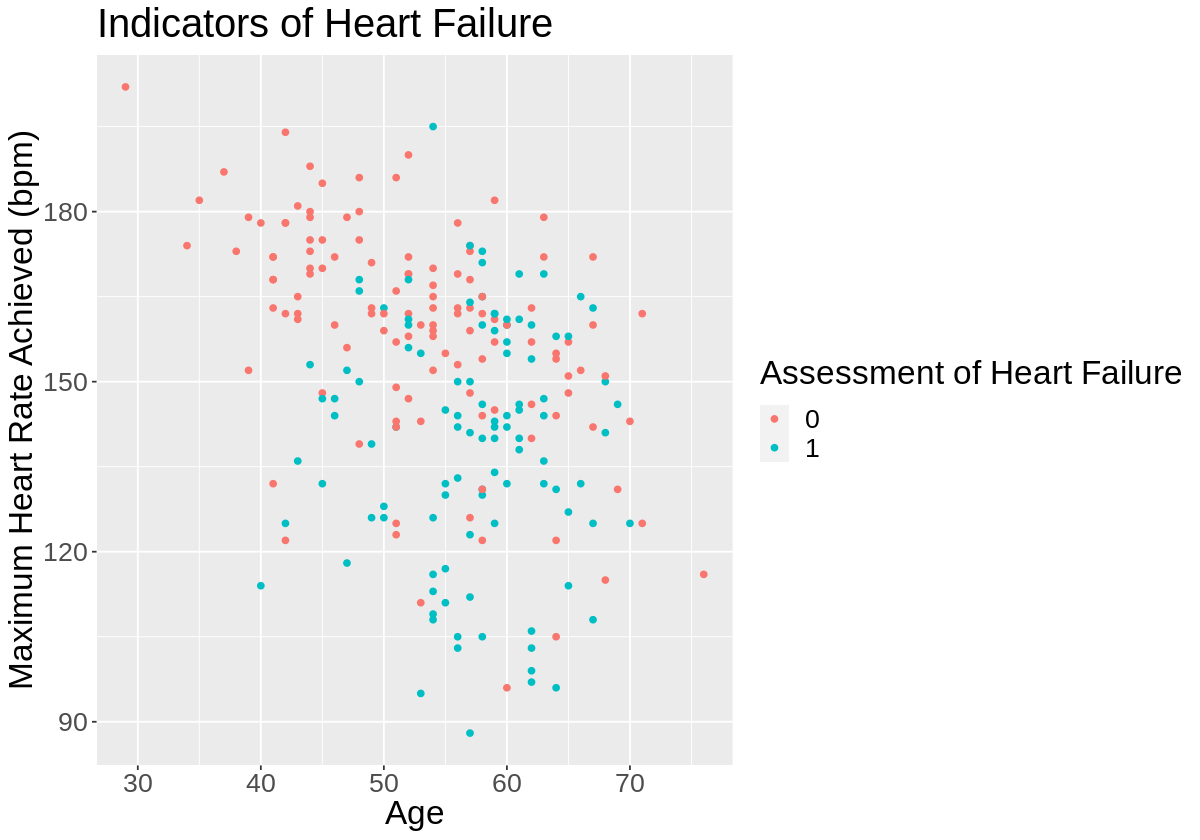

In [29]:
options(repr.plot.width = 10, reppr.plot.height = 10)
cleveland_plot <- cleveland_training %>%
    ggplot(aes(x = age, y = thalach, color = num)) +
    geom_point() +
    labs(x = "Age", y = "Maximum Heart Rate Achieved (bpm)", color = "Assessment of Heart Failure") +
    ggtitle("Indicators of Heart Failure") +
    theme(text = element_text(size=20))
cleveland_plot

<br>
<b>Creating the folds to use for the cross-validation process</b>

In [30]:
heart_fold <- vfold_cv(cleveland_training, v = 5, strata = num)

<br>
<b>Creating the recipe for our classifier</b>

In [31]:
heart_recipe <- recipe(num ~ ., data = cleveland_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [32]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [33]:
gridvals <- tibble(neighbors = c(1:20))

In [34]:
heart_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_spec) %>%
    tune_grid(resamples = heart_fold, grid = gridvals) %>%
    collect_metrics()
heart_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6359420,5,0.03942414,Model01
1,roc_auc,binary,0.6360476,5,0.04113577,Model01
2,accuracy,binary,0.6359420,5,0.03942414,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,roc_auc,binary,0.7754524,5,0.03034614,Model19
20,accuracy,binary,0.6932367,5,0.02226943,Model20
20,roc_auc,binary,0.7763730,5,0.03106711,Model20


In [35]:
k_best <- heart_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    select(neighbors) %>%
    slice(1) %>%
    pull()
k_best

[1] 9

In [36]:
best_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = k_best) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_fit_best <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(best_heart_spec) %>%
    fit(cleveland_training)
heart_fit_best

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_best,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2675439
Best kernel: rectangular
Best k: 9

In [37]:
heart_summary <- heart_fit_best %>%
    predict(cleveland_testing) %>%
    bind_cols(cleveland_testing) %>%
    metrics(truth = num, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
heart_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6266667


In [38]:
# stats for the patient
patient <- tibble(age = 52, thalach = 152)
patient_diagnosis <- predict(heart_fit_best, patient)
patient_diagnosis

.pred_class
<fct>
0


Method and Results: For the data analysis, we will be using two predictors, age and maximum heart rate achieved (bpm), to predict likelihood of heart failure for new observations. We will utilize git for our version control system and GitHub to store our data analysis in a cloud-based repository. 
Using several tidying techniques, we have cleaned and wrangled the data to make it easier to discern. First, we read the data into Jupyter using the read_csv function. Then, we renamed the columns using the original dataset. After that, we selected the columns that correspond to age and maximum heart rate achieved and summarized the data in a table. We also set the seed as a random number, and then split the data into training and testing sets with a proportion of 0.75 for the training data. 
In order to visualize the data, we created a scatter plot with age on the x-axis and maximum heart rate on the y-axis, including human-readable labels and a necessary title to help with the clarity of the visualization. We colored values from 1 to 4, with 0 indicating the absence of heart disease, and numbers 1-4 indicating the severity of the present heart disease (4 being most severe). From here, we can observe the relationship between age and maximum heart rate with regards to heart disease. This will be our main form of visualization since we aim to observe the relationship between two unordered variables.
After conducting a 5-fold cross validation to test different values of k, we were able to create a recipe and model specification. Then, we created a tibble and collected the metrics to pull the best value of k. We used that k-value to create a new model specification and re-fit the data. Once we created a summary, we determined the accuracy of our classifier to be 0.5810811.
After determining accuracy, we created a tibble with the data of our patient, which we could then plug into our model using the predict function. The model predicted that our patient of age 52 and maximum heart rate 152bpm was of predicted class 0, or in other words, our patient was not experiencing heart failure.

"As you consider past data and your patient, you decide you can diagnose the patient as not experiencing heart failure, meaning you now have to break the news to him that his WebMD self-diagnosis was false."

Discussion: Our model determines the extent to which, if at all, a person would experience heart failure based on their age and maximum heart rate. According to our model, we found that the new patient was not experiencing heart failure. Whilst examining the dataset, this prediction seems realistic and it is what we expected to find. Such findings could be used by medical institutions to compare past data with new data and make assumptions, provided our level of 58.108% accuracy is sufficient. They could also be used on a smaller scale, to allow individuals to predict for themselves the likelihood of experiencing heart failure at various times of their life. After completing this analysis, new questions may be posed. For instance, we can consider how our model would change if we included more predictors in our recipe, such as cholesterol or amount of cigarettes smoked per day. We imagine it would provide more valuable predictions, and could increase accuracy of our model. Overall, our findings are valuable and this dataset is worth exploring further to answer more in-depth predictive questions.

References:

David W. Aha & Dennis Kibler. "Instance-Based Prediction of Heart-Disease Presence With the Cleveland Database." (n.d.). Retrieved November 25, 2021, from https://rdrr.io/cran/MixAll/man/HeartDisease.html.

Heart Disease Data Set. UCI Machine Learning Repository. (n.d.). Retrieved November 25, 2021, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. 

Mayo Foundation for Medical Education and Research. (2021, July 21). Heart Failure. Mayo Clinic. Retrieved November 25, 2021, from https://www.mayoclinic.org/diseases-conditions/heart-failure/symptoms-causes/syc-20373142. 